### Piggott-ACSE-fh223

In [1]:
%%html
<style>
div.optional {
    display: block;
    background-color: #d7e2ff;
    border-color: #d7e2ff;
    border-left: 5px solid #d7e2ff;
    padding: 0.5em;
}
div.advanced {
    display: block;
    background-color: #fff4d7;
    border-color: #fff4d7;
    border-left: 5px solid #fff4d7;
    padding: 0.5em;
}
</style>

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation

from matplotlib import rcParams
# font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

### Explicit vs Implicit

The explicit and implicit methods we discuss in the lectures are mainly concerned with numerical methods for solving Ordinary Differential Equations (ODEs) and Partial Differential Equations (PDEs). I focus the comparison on stability and computational efficiency.

**Explicit methods**:
Explicit methods rely directly on known current or previous information at each step of the computation. In the case of the forward Euler method, for example, the new value $y_{n+1}$ can be derived directly from the existing value $y_n$ and the derivative value computed at $y_n$. The advantage of this method is that it is simple to implement and fast to compute, as it does not require solving linear or nonlinear systems of equations. However, the main disadvantage of the explicit method is its stability condition. It is usually limited by the time step, especially for rigid problems, which means that a very small time step may be required to maintain the stability of the numerical solution, which may lead to inefficiency in practical applications.

**Implicit methods**:
In contrast, implicit methods rely on unknown future values when computing new values. For example, the backward Euler method involves derivative values computed at $y_{n+1}$, which means that an equation or system of equations needs to be solved at each step. In contrast to explicit methods, implicit methods, such as implicit Runge-Kutta and Backward Difference Formulas (BDFs), are usually considered A-stable or even L-stable in some cases. This means that for a wide range of time steps, they can handle rigidity efficiently. However, this increased stability comes at the cost of needing to solve a potentially quite complex system of nonlinear equations per time step, especially when nonlinear PDEs are involved. This can be computationally more expensive.


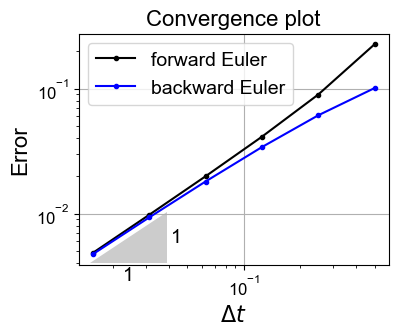

In [3]:
# define physical parameter
K = 2
# initial condition
y0 = 1
# and some numerical parameters
tend = 1.0
# the range of time step sizes we will consider
dts = [0.5/(2**n) for n in range(0, 6)]

def f(t, y):
    return -K*y

def y_ex(t):
    """ Function to evaluate the exact solution to the exponential decay problem with y_r=0
    """ 
    return y0*np.exp(-K*t)


# set up figure
fig, axs = plt.subplots(1, 1, figsize=(4, 3))

# somewhere to store our errors for each time step size
FE_error = np.empty(len(dts))
BE_error = np.empty(len(dts))

# loop over our different time step sizes, compute solution and corresponding error
for (i, dt) in enumerate(dts):
    # our time levels for the numerical solution
    N_dt = int(round(tend/dt))
    t = dt * np.linspace(0, N_dt, N_dt + 1)

    # forward Euler
    y = np.empty(len(t))
    y[0] = y0
    for (n, t_n) in enumerate(t[:-1]):
        # note for this example this is the same as y[n]*(1-dt*K)
        y[n+1] = y[n] + dt * f(t_n, y[n])

    FE_error[i] = np.linalg.norm(y - y_ex(t))/np.sqrt(len(y))

    # backward Euler
    y = np.empty(len(t))
    y[0] = y0
    for n in range(0, len(t) - 1):
        # for this simple problem we can rearrange the implicit expression
        # and hence do not need to use the f function - if we did we would
        # need to use an implicit equation solver.
        y[n+1] = y[n]/(1 + dt*K)

    BE_error[i] = np.linalg.norm(y - y_ex(t))/np.sqrt(len(y))

axs.loglog(dts, FE_error, 'k.-', label='forward Euler')
axs.loglog(dts, BE_error, 'b.-', label='backward Euler')

axs.set_xlabel('$\Delta t$', fontsize=16)
axs.set_ylabel('Error', fontsize=16)
axs.set_title('Convergence plot', fontsize=16)
axs.grid(True)
axs.legend(loc='best', fontsize=14)
annotation.slope_marker((1.5e-2, 4e-3), (1, 1), ax=axs,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))


The FE and BE methods at steady state have similar accuracy.

**Explicit Method Stability Analysis**:
For explicit methods, such as the forward Euler method, the stability condition requires $ |1+\lambda\Delta t|<1 $. This means that for a given complex number $\lambda$, the method is stable only if the time step $\Delta t$ is small enough such that the values $ (1+\lambda_R\Delta t) $ and $ (\lambda_I\Delta t) $ fall within a circle centred at (-1,0) with radius 1. Therefore, for \$\lambda$ with a large real part, a smaller $\Delta t$ needs to be chosen to maintain stability.

**Implicit Methods Stability Analysis**:
Implicit methods, such as the backward Euler method, are usually more relaxed in their choice of $\Delta t$. For example, in the backward Eulerian method, the stability condition does not depend on the time-step restriction because the update formula $ z_{n+1} = \frac{z_n}{1-\lambda\Delta t} $ naturally guarantees that $ |z_{n+1}| $ will not exceed $ |z_n| $ as long as $\lambda_R < 0$. As a result, implicit methods can remain stable even for $\lambda$ with a large negative real part, which makes them well-suited for solving rigid problems.

Text(0.4, 0.1, 'Unstable')

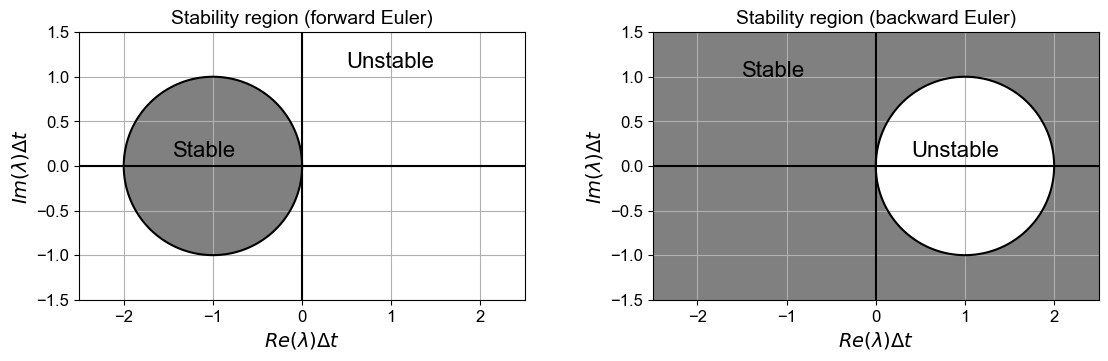

In [4]:
# let's calculate and plot the stability region for our discrete schemes
x = np.linspace(-2.5, 2.5, 250)
y = np.linspace(-1.5, 1.5, 100)
xx, yy = np.meshgrid(x, y)
lamdt = xx + 1j*yy

# forward Euler amplification factor,  and its magnitude
FEamp = 1 + lamdt
FEampmag = np.abs(FEamp)

# backward Euler amplification factor,  and its magnitude
BEamp = 1.0/(1 - lamdt)
BEampmag = np.abs(BEamp)

# set up our figs for plotting
fig, axs = plt.subplots(1, 2, figsize=(11, 7))
fig.tight_layout(w_pad=5, h_pad=5)
# reshape the list of axes as we are going to use in a loop
axs = axs.reshape(-1)

# plot the forward Euler stability region
axs[0].contour(x, y, FEampmag, [1.0], colors=('k'))
axs[0].contourf(x, y, FEampmag, (0.0, 1.0), colors=('grey'))
axs[0].set_aspect('equal')
axs[0].grid(True)
axs[0].set_xlabel('$Re(\lambda)\Delta t$', fontsize=14)
axs[0].set_ylabel('$Im(\lambda)\Delta t$', fontsize=14)
axs[0].set_title('Stability region (forward Euler)', fontsize=14)
axs[0].axhline(y=0, color='k')
axs[0].axvline(x=0, color='k')
axs[0].text(-1.45, 0.1, 'Stable', fontsize=16)
axs[0].text(0.5, 1.1, 'Unstable', fontsize=16)

# plot the backward Euler stability region
axs[1].contour(x, y, BEampmag, [1.0], colors=('k'))
axs[1].contourf(x, y, BEampmag, (0.0, 1.0), colors=('grey'))
axs[1].set_aspect('equal')
axs[1].grid(True)
axs[1].set_xlabel('$Re(\lambda)\Delta t$', fontsize=14)
axs[1].set_ylabel('$Im(\lambda)\Delta t$', fontsize=14)
axs[1].set_title('Stability region (backward Euler)', fontsize=14)
axs[1].axhline(y=0, color='k')
axs[1].axvline(x=0, color='k')
axs[1].text(-1.5, 1.0, 'Stable', fontsize=16)
axs[1].text(0.4, 0.1, 'Unstable', fontsize=16)


**The decision between stability and efficiency**:
The choice between explicit or implicit methods usually depends on the trade-off between stability and efficiency. If the problem is non-rigid and there is a high demand for computational speed, then explicit methods may be preferred. However, if the problem is rigid or requires numerical stability over a long time, then implicit methods may be a better choice.

**Similarities**:
Although explicit and implicit methods differ in stability and computational efficiency, they are similar in the goal of numerical analysis: both aim to solve differential equations through numerical approximation. They are both based on a discretisation of the problem with a finite number of steps to approximate a continuous process, and both rely on a good understanding of the problem, including an assessment of its properties and the accuracy required for the numerical solution.

In addition, the effectiveness of either explicit or implicit methods is related to the chosen time step $\Delta t$. In terms of stability and analysis of the convergence order, both methods require an estimate of the LTE, which is computed by substituting the exact solution into the numerical scheme.Both explicit and implicit methods can estimate the order of convergence by plotting $\tau$ against $\Delta t$ on a log-log plot. This approach can help us to understand and compare the accuracy of different numerical schemes and to choose the most appropriate method in practice.

In the lecture, we discussed rigidity problems and why implicit methods are preferred to explicit methods in dealing with such problems. By comparing the stability theories of the two methods and analysing their stability regions, we can better understand why implicit methods are more appropriate in certain situations. Moreover, for the computational cost in the implicit methods, we can further explore this by implementing and comparing different linear and nonlinear solvers to see which method is more efficient in practical applications.

### Runge-Kutta vs Linear multistep

In this discussion, I will focus on the accuracy and flexibility of application of the Runge-Kutta method and the linear multistep method.

**Runge-Kutta Methods**:
Runge-Kutta methods are single-step procedures, meaning that the calculation of the current step only relies on the information from the immediately preceding step, without the need for a history of previous values, we do not have the self-starting issue. This single-step nature facilitates the implementation of adaptive time-stepping, which can dynamically adjust the precision required for the problem at hand. The high accuracy of these methods, especially in higher-order implementations such as the RK4, stems from multiple derivative evaluations within each step, forming a weighted average to estimate the next value. While this increases the accuracy, it can also raise the computational cost, making RK methods more suited for problems where high precision is essential and computational resources are less of a constraint.

**Linear Multistep Methods**:
Linear multistep methods predict future values by utilizing not only the current but also multiple past computed points, which can be in either explicit or implicit forms. Explicit multistep methods are generally easier to implement but may lack the stability that implicit methods offer, especially for stiff problems. A distinct advantage of multistep methods is their efficiency in long-term integrations after the initial startup phase(self-starting), typically requiring fewer function evaluations per step. However, they necessitate the storage of multiple past points, which increases memory usage and can be a limiting factor for large-scale or long-duration computations. The implementation of these methods involves a self-starting algorithm that calculates enough initial steps to begin the multistep process, which adds to the complexity of the algorithm, especially when time steps need to be adjusted dynamically during the computation.


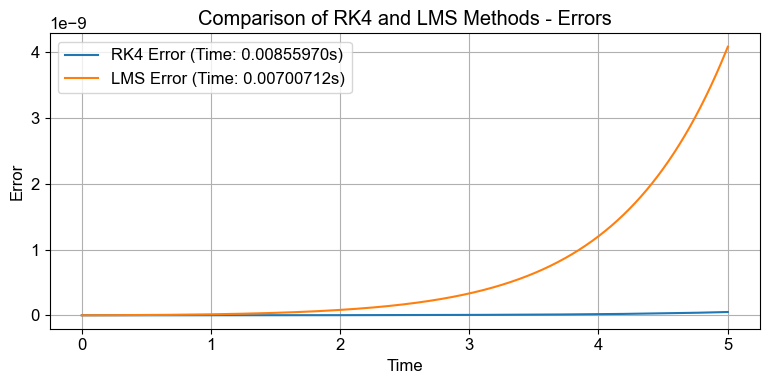

In [5]:
def f(t, y):
    return y

def RK4(f, y0, t0, t_max, dt):
    y = np.array(y0)
    t = np.array(t0)
    y_all = [y0]
    t_all = [t0]                 
    while t < t_max:
        k1 = dt*f(t, y)
        k2 = dt*f(t + 0.5*dt, y + 0.5*k1)
        k3 = dt*f(t + 0.5*dt, y + 0.5*k2)
        k4 = dt*f(t + dt, y + k3)
        y = y + (1./6.)*(k1 + 2*k2 + 2*k3 + k4)
        y_all.append(y)
        t = t + dt
        t_all.append(t)
    return np.array(y_all), np.array(t_all)

def AB4(f, y0, t0, t_max, dt):
    y = np.array(y0)
    t = np.array(t0)
    y_all = [y0]
    t_all = [t0]

    # Starting AB4 with RK4 steps
    for n in range(3):
        k1 = dt*f(t, y)
        k2 = dt*f(t + 0.5*dt, y + 0.5*k1)
        k3 = dt*f(t + 0.5*dt, y + 0.5*k2)
        k4 = dt*f(t + dt, y + k3)
        y = y + (1./6.)*(k1 + 2*k2 + 2*k3 + k4)
        y_all.append(y)
        t = t + dt
        t_all.append(t)
        
    # Compute AB4 coefficients
    LHS_A = np.array([ [1., 1., 1., 1.], [0., -1., -2., -3.], [0., 0., 2., 6.], [0., 0., 0., -6.] ])
    RHS_b = np.array([1., 1./2., 5./6., 9./4.])
    AB4_beta = np.linalg.solve(LHS_A, RHS_b)             
    while t < t_max:
        y = y + dt * (AB4_beta[0]*f(t, y_all[-1]) + AB4_beta[1]*f(t-dt, y_all[-2]) 
                    + AB4_beta[2]*f(t-2*dt, y_all[-3]) + AB4_beta[3]*f(t-3*dt, y_all[-4]))
        y_all.append(y)
        t = t + dt
        t_all.append(t)
    return np.array(y_all), np.array(t_all)

# Adjusted parameters for more clear visualization
dt = 0.002  # Smaller time step
y0 = 1.0
t0 = 0.0
t_max = 5   # Increased simulation time

start_time = time.time()
rk4_y, rk4_t = RK4(f, y0, t0, t_max, dt)
rk4_time = time.time() - start_time

start_time = time.time()
ab4_y, ab4_t = AB4(f, y0, t0, t_max, dt)
ab4_time = time.time() - start_time

# Calculate errors
rk4_error = np.abs(rk4_y - np.exp(rk4_t))
ab4_error = np.abs(ab4_y - np.exp(ab4_t))

# Plotting results with error plots
plt.figure(figsize=(8, 4))

# Subplot for the errors
plt.plot(rk4_t, rk4_error, label=f'RK4 Error (Time: {rk4_time:.8f}s)')
plt.plot(ab4_t, ab4_error, label=f'LMS Error (Time: {ab4_time:.8f}s)')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Comparison of RK4 and LMS Methods - Errors')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Algorithm Implementation and Computational Efficiency**:
The differences in algorithm implementation between RK and LMS methods significantly affect their applicability to various types of problems. RK methods, with their inherent simplicity due to the single-step approach, are easier to code and enable straightforward adaptive step size adjustments. In contrast, LMS methods, while potentially more efficient over long integrations, require a more complex initiation process to establish the necessary historical data, and their efficiency might be challenged when the problem's dynamics change significantly throughout the integration process. Another advantage of the LMS scheme is that we can store and reuse the function evaluation results, thus reducing some of the costs of adopting a higher-order scheme. This is a potential advantage if the cost of evaluating functions is high. However, with the RK approach, we are unable to reuse this information as we move to the next time step.

**Similarities Between RK and LMS Methods**:
Despite their differences, RK and LMS methods share several similarities:
- **Solving the Same Class of Problems**: Both methods are used for solving ordinary differential equations (ODEs), aiming to find numerical solutions to these equations.
- **Iterative Nature**: They are iterative in approach, using step-by-step approximations to converge towards a solution.
- **Importance of Numerical Stability**: Stability is a key consideration in both methods, although their specific stability properties may differ.
- **Trade-off Between Accuracy and Efficiency**: Both methods involve a trade-off between computational accuracy and efficiency.
- **Approximation of Numerical Solutions**: They approximate solutions rather than finding exact analytical answers, subject to the limitations of numerical approximation and rounding errors.

To summarize, the choice between RK and LMS methods should be influenced by the specific requirements of accuracy, the need for adaptive step sizing, computational resource availability, and the complexity of the problem being solved. The RK methods offer ease of implementation and high precision, making them preferable for rapidly-changing solutions or when high accuracy is needed in a short time frame. On the other hand, LMS methods are more resource-efficient over long simulations but require careful consideration of memory management and initial self-starting computations. Hybrid approaches that combine the strengths of both methods may be developed for specific applications to achieve the desired balance of efficiency, accuracy, and stability.


### Finite difference vs Finite element

Finite Difference Methods (FDM) and Finite Element Methods (FEM) are the two main techniques used in numerical analysis to solve Partial Differential Equations (PDEs). In comparing these two methods, I will focus on their range of applications and geometric adaptations.

**Finite Difference Method (FDM)**:
- **Approach**: FDM involves approximating derivatives using methods such as forward, backward, or centre differences, based on Taylor series expansions.
- **Application**: It is particularly effective for steady-state or unsteady convection-diffusion problems, with the choice between centre difference or upwind difference methods for discretizing convection and diffusion terms.
- **Suitability**: Best suited for problems that can be naturally discretised into regular grids, especially within Cartesian coordinate systems.
- **Complex Geometries**: FDM faces challenges in dealing with complex geometries and boundaries due to the need for interpolation on non-regular grids, potentially reducing accuracy.
- **Stability and Accuracy**: 
    - Centre difference schemes may lead to instability, particularly with convective terms when the grid Peclet number exceeds 2, causing oscillations or overshoots/undershoots.
    - The upwind scheme, while reducing instability in convective terms, is only first-order accurate and introduces numerical diffusion. This aspect can lead to deviations in the physical behaviour of the numerical solution from the actual problem.
    - Stability concerns are often governed by the Courant-Friedrichs-Lewy (CFL) condition, influencing the time step size.

**Finite Element Method (FEM)**:
- **Approach**: FEM solves the weak form of differential equations by approximating the solution function across the entire domain.
- **Geometric Flexibility**: Highly adaptable to complex geometries and boundary conditions, allowing elements to be flexibly adapted to fit arbitrary shapes.
- **Applications**: Commonly used in engineering and physics for modelling the distribution of physical fields and accommodating various boundary conditions.
- **Material and Boundary Variability**: Beneficial for problems with varying material properties within elements, accommodating a wide range of boundary conditions, including Dirichlet, Neumann, or mixed.
- **Solution Consistency**: Provides a solution that is effective everywhere within the domain, not just at discrete points.
- **Implementation Complexity**: While potentially more complex to implement than FDM, FEM offers greater accuracy, particularly for problems with irregular geometries and complex boundary conditions.

**Mesh Data Structure**:
- **FEM Meshing**: Typically uses unstructured grids describable by connectivity matrices. This allows for extension to higher dimensions and complex geometries.
- **Element Definition**: Elements, cells, or "finite volumes" in FEM are discrete objects used to tessellate an entire domain. The vertices define the geometry, and nodes represent locations where the unknowns are solved.

The core difference between the two methods is how they deal with the discretisation of the problem.FDM approximates the differential equations directly at discrete points, whereas FEM creates a system of approximate functions that are valid over the whole domain, not just at discrete points. This treatment of FEM allows it to obtain theoretically powerful results about errors, and stability.

**Similarities between FEM and FDM**:
- **Numerical Solutions for PDEs**: Both FDM and FEM are powerful numerical techniques used for solving Partial Differential Equations (PDEs) in various fields.
- **Discretization of Continuum Problems**: Each method involves converting continuous problems into a discrete form. FDM does this by discretizing the derivatives at specific points, while FEM discretizes the entire solution domain into finite elements.
- **Boundary and Initial Conditions**: Both methods require careful handling of boundary and initial conditions to ensure accurate and realistic modelling of physical problems.
- **Numerical Approximation and Error**: FDM and FEM both approximate the solutions of PDEs, which means they inherently introduce numerical errors.

**Choosing Between FDM and FEM**:
When selecting between FDM or FEM for practical applications, we should consider the problem's geometric complexity, boundary condition intricacies, and any time dependency. FEM is generally more favourable for problems requiring high geometric adaptability and complex boundary conditions. FDM is more straightforward conceptually and might be better for problems with simpler geometries or those fitting well into regular meshes.
